In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                ("visited", len(current.visited)),
                ("WorkSnowball", len(current.related)),
                ("selected", len(current.final_selected)),
                ("seed_set", len(current.seed_set)),
            ]
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            ("found", len(current.delta_visited)),
                            ("WorkSnowball", len(current.delta_related)),
                            ("selected", len(current.delta_selected)),
                            ("seed_set", len(current.delta_seed_set)),
                        ]
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array
#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários 22 do Seed Set + 29 Snowballing: ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))

Total de estudos primários 22 do Seed Set + 29 Snowballing:  51


In [4]:
print ("Lista de estudos primários usados como Seed Set + Snowballing:")
({x for _, x in load_work_map_all_years() if x.category == "snowball"}) @ metakey_title

Lista de estudos primários usados como Seed Set + Snowballing:


['cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'kautz2000a - Applying and adjusting a software process improvement model in practice: the use of the IDEAL model in a small software enterprise',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'armbrust2010a - Determining organization-specific process suitability',
 'mandić2010d - SAS: A tool for the GQM+ strategies grid derivation process',
 'guzmán2010a - Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations',
 'wang2005a - Measuring and improving software process in China',
 'mccoy1998a - Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics',
 'mandić2010b - Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals',
 "reiblein1997a - SPI:\x91I can't get no satisfaction\x92-directing pro

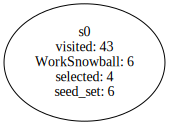

In [5]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("ieee2015", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
FinalSelection(state)

In [6]:
strategy.initial.seed_set @ metakey_title

['basili2010a - Linking software development and business strategy through measurement',
 'sommerville1999a - Managing process inconsistency using viewpoints',
 'mandić2010a - Utilizing GQM+ Strategies for an organization-wide earned value analysis',
 'wang2005a - Measuring and improving software process in China',
 'kaneko2011a - Application of GQM+ Strategies{\textregistered} in the Japanese space industry',
 'waina2001a - A business goal-based approach to achieving systems engineering capability maturity']

In [7]:
strategy.initial.visited @ metakey_title

['hongying2011a - A customizable agile software Quality Assurance model',
 'software2002a - Attaining Level 5 in CMM process maturity',
 'khoshkbarforoushha2010a - Towards a Metrics Suite for Measuring Composite Service Granularity Level Appropriateness',
 'koznov2011a - Process Model of DSM Solution Development and Evolution for Small and Medium-Sized Software Companies',
 'wang2005a - Measuring and improving software process in China',
 'duka2010a - Fault Slip Through measurement in software development process',
 'rolland2010a - Business Process Lines to Deal with the Variability',
 'chastek2011a - Engineering a Production Method for a Software Product Line',
 'ponisio2008a - Analysing Boundary Objects to Develop Results that Support Business Goals',
 'basili2010a - Linking software development and business strategy through measurement',
 'betz2011a - Risk-Aware Business Process Modeling and Simulation Using XML Nets',
 'nunes2011a - Dynamic process adaptation: A context-aware appro

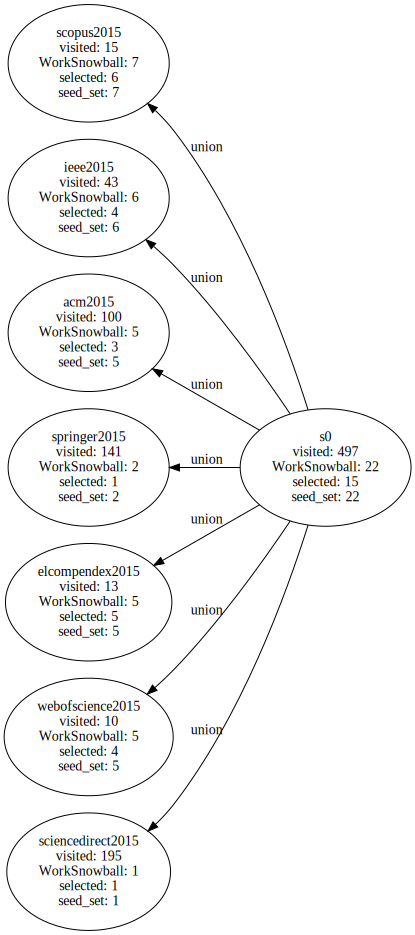

In [8]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus2015", "ieee2015", "acm2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015"], filter_function)
#strategy.initial.find("acm")
FinalSelection(strategy.initial)

In [9]:
strategy.initial.visited

{Using strategic planning for selection of SPI processes: An experience report,
 Perturbation-based user-input-validation testing of web applications,
 Hybrid genetic algorithm and association rules for mining workflow best practices,
 Business Process Lines to Deal with the Variability,
 Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals,
 Investigating the relationship between schedules and knowledge transfer in software testing,
 A systematic literature review on the industrial use of software process simulation,
 Engineering a Production Method for a Software Product Line,
 The Agile Practices Impact Model: Idea, Concept, and Application Scenario,
 A case study in innovative process improvement: code synthesis from formal specifications,
 The Effect of Improving IT Standard in IT Governance,
 Process excellence and capability determination,
 Software quality and IS project performance improvements from software development process matur

In [10]:
array = []

print ("--- Estratégia 1 (E1) ---")

name = "E1"
EP = len (strategy.initial.related) / len (strategy.initial.visited)
print ("Precision Seed Set: " + "%.2f" %(EP*100))

ER = len (strategy.initial.related) / 22
print ("Recall: " + "%.2f" %(ER*100))

FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.2f" %(FS*100))

PF = len (strategy.initial.final_selected)/len (strategy.initial.visited)
print ("Precision Seleção Final: " + "%.2f" %(PF*100))

RF = len (strategy.initial.final_selected)/ 22 
print ("Recall Seleção Final: " + "%.2f" %(RF*100))

FF = 2*((PF*RF)/(PF+RF))
print ("F-Measure Seleção Final: " + "%.2f" %(FF*100))

#array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---
Precision Seed Set: 4.43
Recall: 100.00
F-Measure: 8.48
Precision Seleção Final: 3.02
Recall Seleção Final: 68.18
F-Measure Seleção Final: 5.78


In [11]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

1,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.139535,0.117647,0.12766,0,0,0,-,6,43,0,6,43,4,0.139535,0.117647,0.12766,0.0930233,0.133333,0.109589


In [12]:
array

[['E1',
  6,
  43,
  4,
  0.13953488372093023,
  0.11764705882352941,
  0.1276595744680851,
  0.09302325581395349,
  0.13333333333333333,
  0.1095890410958904]]

## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

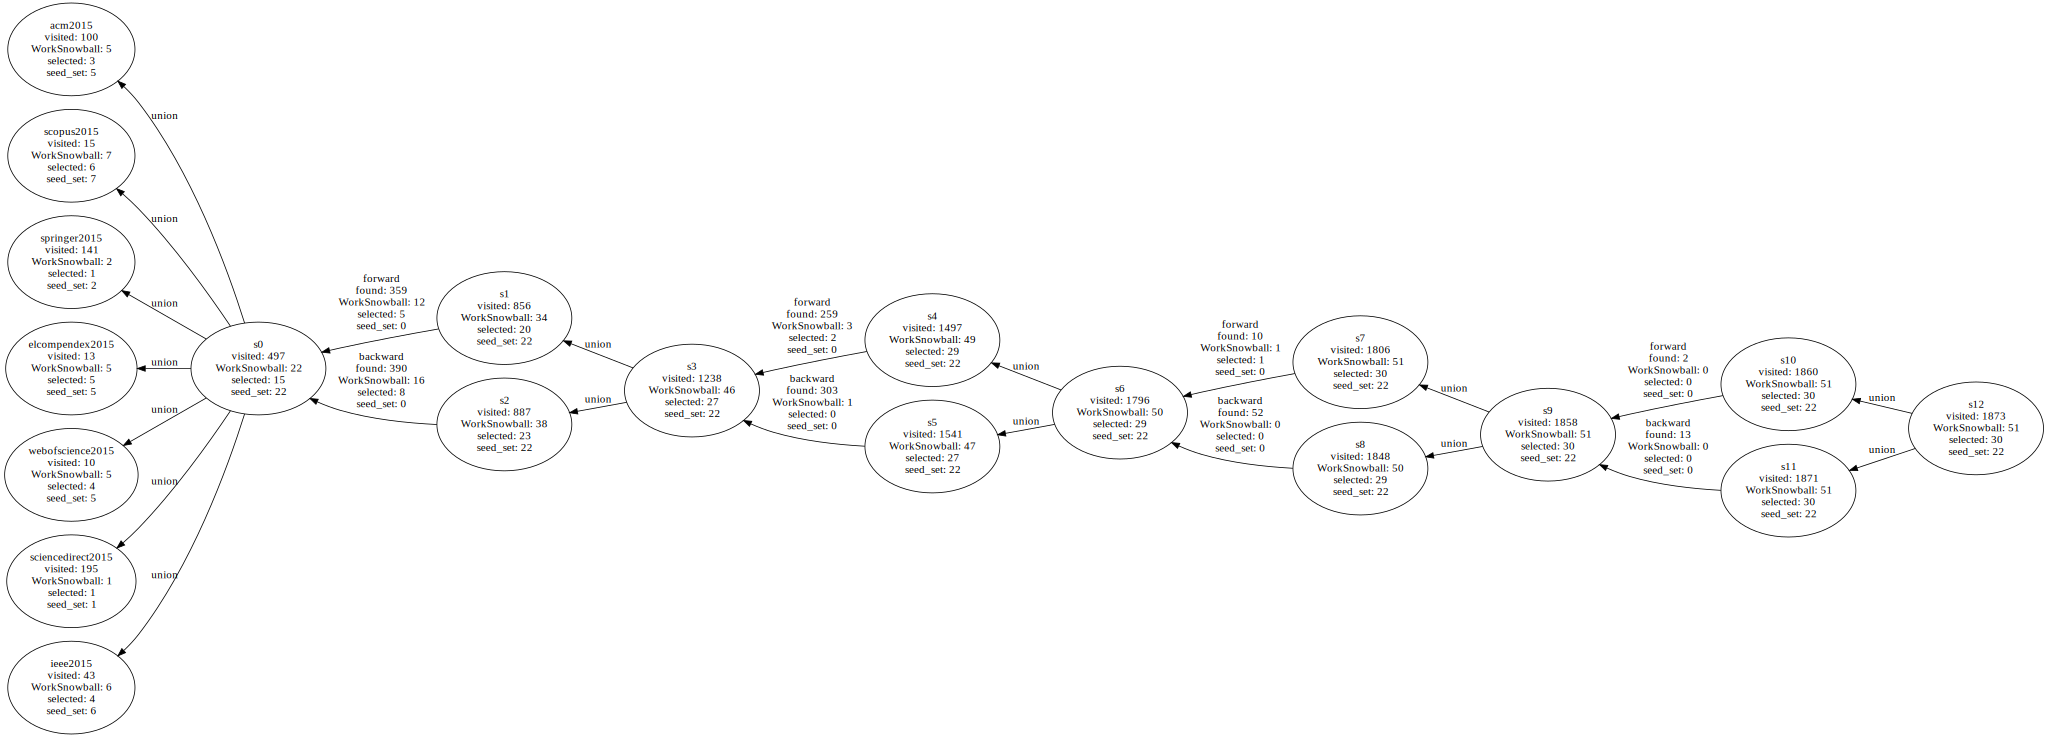

In [13]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm2015", "scopus2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015", "ieee2015"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

FinalSelection(state)

In [14]:
state.final_selected @ metakey

['kautz2000a',
 'trendowicz2014a',
 'armbrust2010a',
 'guzmán2010a',
 'mccoy1998a',
 'reiblein1997a',
 'karlström2002a',
 'barreto2010a',
 'basili2007c',
 'basili2010a',
 'plösch2011a',
 'trienekens2004a',
 'mcloughlin2010b',
 'becker2008a',
 'becker2008b',
 'sommerville1999a',
 'trienekens2009a',
 'münch2013c',
 'liu2005a',
 'waina2001a',
 'mcloughlin2010a',
 'albuquerque2009a',
 'esfahani2011a',
 'sun2010a',
 'debou2000a',
 'trienekens2005a',
 'kowalczyk2010a',
 'basili2007b',
 'basili2007a',
 'kaneko2011a']

In [15]:
state.find("sciencedirect2015").final_selected @ metakey_title

['trienekens2005a - Business-oriented process improvement: practices and experiences at Thales Naval The Netherlands (TNNL)']

### Resumo 

#### Resumo da Busca em DL

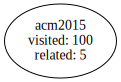

In [16]:
strategy.initial.find("acm2015")

In [17]:
# Visitados ACM
strategy.initial.find("acm2015").visited

{Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals,
 Exploring the use of the cynefin framework to inform software development approach decisions,
 The Agile Practices Impact Model: Idea, Concept, and Application Scenario,
 A methodology for exploring students' experiences and interaction with large-scale software through role-play and phenomenography,
 Investigating a Conceptual Construct for Software Context,
 Applying ISO 9001: 2000, MPS.BR and CMMI to Achieve Software Process Maturity: BL Informatica's Pathway,
 An Approach to Identify Commonalities in Web Application Engineering for a Web Content Management System,
 Cloud-based support for global software engineering: Potentials, risks, and gaps,
 Free/Open Source Software Development,
 Migrating towards evolving software product lines: challenges of an SME in a core customer-driven industrial systems engineering context,
 A Model for Assessing Organizational Learning in Software Deve

In [18]:
# Relacionados ACM - encontrado no seed set
strategy.initial.find("webofscience2015").related

{An approach to support the strategic alignment of software process improvement programs,
 Software process improvement: Supporting the linking of the software and the business strategies,
 ProPAMet: a Metric for process and project alignment,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations}

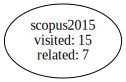

In [19]:
strategy.initial.find("scopus2015")

In [20]:
print("Visitados Scopus:")
strategy.initial.find("scopus2015").visited

Visitados Scopus:


{Using strategic planning for selection of SPI processes: An experience report,
 An approach to support the strategic alignment of software process improvement programs,
 Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Software process improvement for the airline industry,
 Demanding change: How to remain in business despite IT,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Critical success factors in software process improvement: A systematic review,
 SPI:I can't 

In [21]:
print("Relacionados Scopus - encontrado no seed set:")
strategy.initial.find("scopus2015").related

Relacionados Scopus - encontrado no seed set:


{Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [22]:
print("Artigo comum a ACM e Scopus:")
strategy.initial.find("acm2015").visited & strategy.initial.find("scopus2015").visited

Artigo comum a ACM e Scopus:


set()

#### Resumo do Snowballing

In [23]:
#Total de visitados = visitados no final - visitados no início
print ("Total visitados:")
len(state.visited - state.find("s0").visited)

Total visitados:


1376

In [24]:
# Descrição dos Relacionados = relacionados no final - relacionados no início
print ("Total Relacionados: Lista dos que foram encontrados via Snowballing")
state.related - state.find("s0").related

Total Relacionados: Lista dos que foram encontrados via Snowballing


{Application of GQM+ Strategies in a small software development unit,
 Aligning Organizations Through Measurement,
 Determining organization-specific process suitability,
 SAS: A tool for the GQM+ strategies grid derivation process,
 Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics,
 Aggregating viewpoints for strategic software process improvementa method and a case study,
 GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement,
 Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach,
 Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA),
 A framework for systematic evaluation of process improvement priorities,
 A Cynefin based approach to process model tailoring and goal alignment,
 Business objectives as drivers for process improvement: Practices and experiences at Tha

In [25]:
print ("Encontrados via somente Snowballing:")
diff_related = state.related - state.find("s2").related
diff_related @ metakey_title

Encontrados via somente Snowballing:


['mcloughlin2010a - The Rosetta Stone Methodology - A benefits-driven approach to software process improvement',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
 'mcloughlin2010b - The Rosetta Stone Methodology - A benefits-driven approach to SPI',
 'cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'armbrust2010b - Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA)',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'birkhölzer2011a - A framework for systematic evaluation of process improvement priorities',
 'armbrust2010a - Determining organization-specific process suitability',
 'sun2010a - Business-oriented software process improvement based on CMMI using QFD',
 'liu2006a - Business-oriented software process improvement based on CMM using QFD',
 'trienekens2004a - Business objectives as dr

### Detalhamento por Estado / Aresta

#### Estado S0

#### Visitados

In [26]:
#S0 - Visitados
print("Visitados no Estado 0:")
state.find("s0").visited

Visitados no Estado 0:


{Using strategic planning for selection of SPI processes: An experience report,
 Perturbation-based user-input-validation testing of web applications,
 Hybrid genetic algorithm and association rules for mining workflow best practices,
 Business Process Lines to Deal with the Variability,
 Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals,
 Investigating the relationship between schedules and knowledge transfer in software testing,
 A systematic literature review on the industrial use of software process simulation,
 Engineering a Production Method for a Software Product Line,
 The Agile Practices Impact Model: Idea, Concept, and Application Scenario,
 A case study in innovative process improvement: code synthesis from formal specifications,
 The Effect of Improving IT Standard in IT Governance,
 Process excellence and capability determination,
 Software quality and IS project performance improvements from software development process matur

#### Relacionados - Seed Set

In [27]:
#S0 - Relacionados - Encontrados via busca e que existem na lista dos Incluídos da SLR existente - são os seed set!
print("Relacionados no Estado 0: Seed Set")
state.find("s0").related @ metakey_title

Relacionados no Estado 0: Seed Set


['kautz2000a - Applying and adjusting a software process improvement model in practice: the use of the IDEAL model in a small software enterprise',
 'guzmán2010a - Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations',
 'wang2005a - Measuring and improving software process in China',
 'mandić2010b - Utilizing GQM+ Strategies for business value analysis: An approach for evaluating business goals',
 "reiblein1997a - SPI:\x91I can't get no satisfaction\x92-directing process improvement to meet business needs",
 'barreto2010a - Defining and monitoring strategically aligned software improvement goals',
 'oConnor2015a - Exploring the use of the cynefin framework to inform software development approach decisions',
 'basili2010a - Linking software development and business strategy through measurement',
 'plösch2011a - Software engineering strategies: aligning software process improvement wit

#### Aresta s0 -> s2 (Backward - Iteração 1)

In [28]:
# S2 - Backward (Found) - Visitados na iteração 1
print("Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_visited

Backward - Qtd Referencias dos artigos visitados para chegar ao Estado 2, a partir do Estado 0:


{A basis for process improvement in application management,
 Information Technology - Process Assessment - Part 5: An exemplar Process Assessment Model,
 Strategy Maps: Converting Intangible Assets Into Tangible Outcomes,
 Value-based software engineering,
 Using ViewPoints for Inconsistency Management,
 PMBOK - A Guide to the Project Management Body of Knowledge,
 Management indicators model to evaluate performance of IT organizations,
 How complexity domain impacts software development process,
 A Cynefin based approach to process model tailoring and goal alignment,
 You Are What You Measure,
 Artificial intelligence for monitoring and supervisory control of process systems,
 Combining quantitative and qualitative assessment methods in software process improvement,
 An approach for evaluating business goals,
 Determining the applicability of agile practices to mission and life-critical systems,
 The IT Infrastructure Library (ITIL) Service Delivery,
 Successful Software Process Impro

In [29]:
# S2 - Backward (Related) - Encontrados na iteração 1, via snowballing, que não foi encontrado via busca para o seed set.
print("Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:")
state.find("s2").delta_related @ metakey_title

Relacionados encontrados via Backward, para chegar ao Estado 2, a partir do Estado 0:


['liu2005a - QFD application in software process management and improvement based on CMM',
 'basili2007c - GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement',
 'hinley1995a - A goal-oriented approach for managing software process change',
 'basili2007a - Bridging the gap between business strategy and software development',
 'debou2000a - Linking software process improvement to business strategies: experiences from industry',
 'mandić2010d - SAS: A tool for the GQM+ strategies grid derivation process',
 'lepmets2014a - A Cynefin based approach to process model tailoring and goal alignment',
 'kowalczyk2010a - Aligning software-related strategies in multi-organizational settings',
 'messnarz1999a - Better Software Practice for Business Benefit: Principles and Experiences',
 'trendowicz2011a - Aligning software projects with business objectives',
 'martins2007b - ProPAM: SPI based on Process and Project Alignment',
 'mccoy1998a - Inter

#### Aresta s0 -> s1 (Forward - Iteração 1)

In [30]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['cocozza2014a - Application of GQM+ Strategies in a small software development unit',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach',
 'armbrust2010b - Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA)',
 'trendowicz2014a - Aligning Organizations Through Measurement',
 'armbrust2010a - Determining organization-specific process suitability',
 'sun2010a - Business-oriented software process improvement based on CMMI using QFD',
 'mandić2010d - SAS: A tool for the GQM+ strategies grid derivation process',
 'trendowicz2011a - Aligning software projects with business objectives',
 'münch2013a - The effects of gqm+ strategies on organizational alignment',
 'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
 'unterkalmsteiner2014a - A conceptual framework for SPI evaluation',
 'karlstr

#### Relacionados - Encontrados Via Backward e Forward

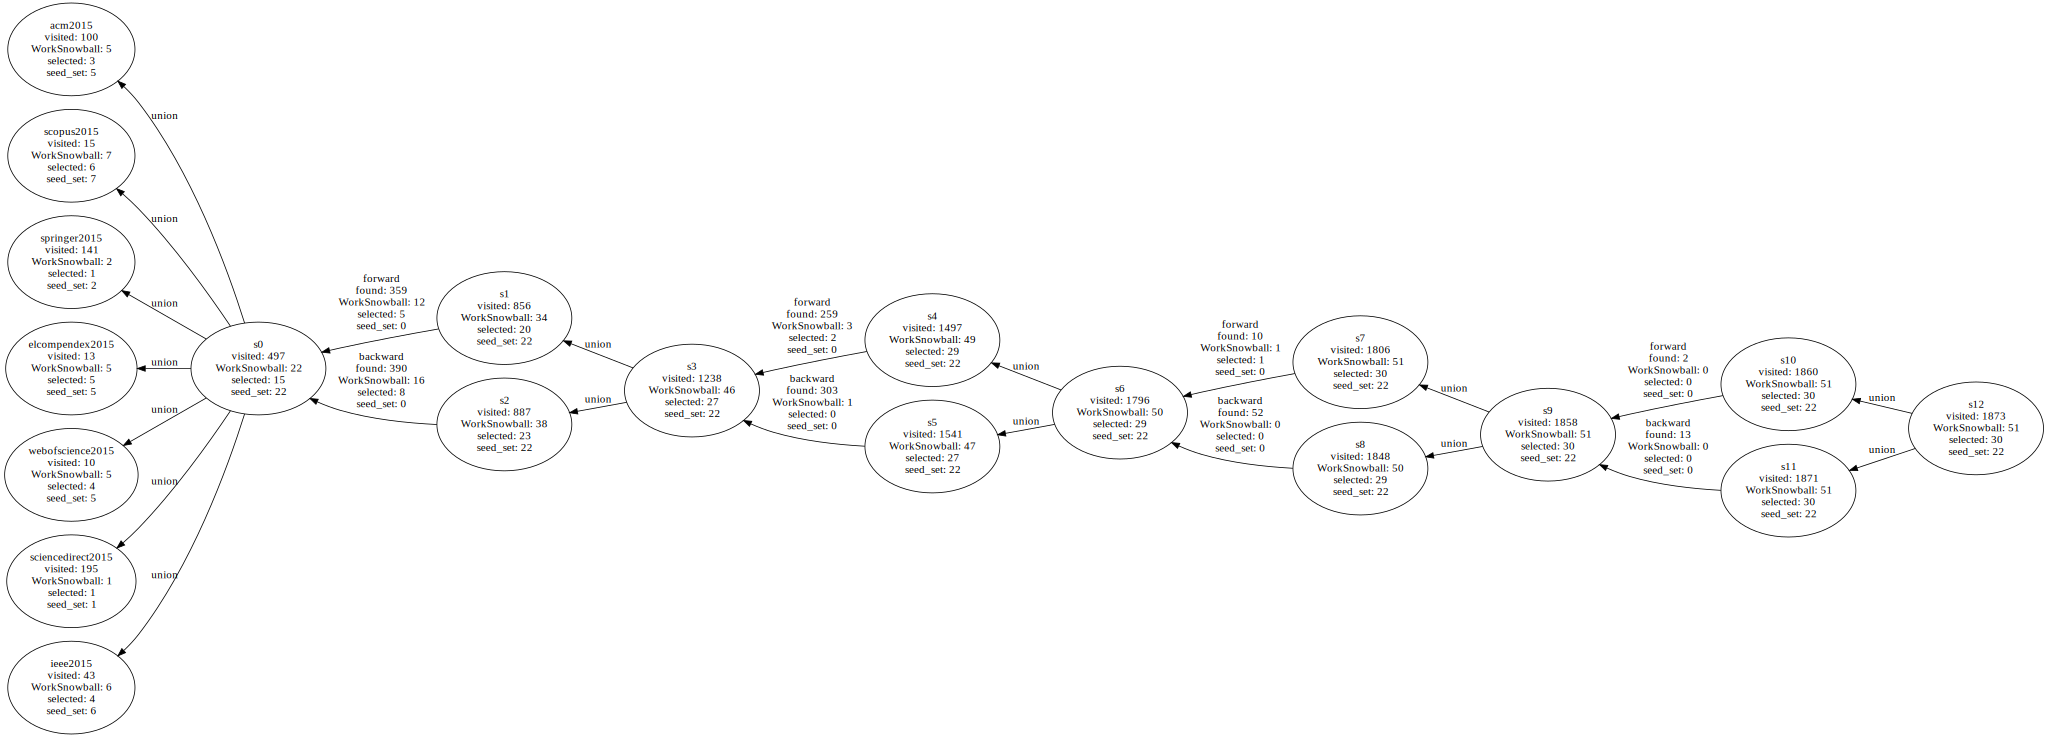

In [31]:
FinalSelection(state)

In [32]:
# Quantidade de artigo que existe em mais de uma biblioteca, após a união, no Estado S0, Ex, existe 1 artigo em acm e scopus.
state.find("s0").previous[0][1]

(len(strategy.initial.find("acm2015").visited) + len(strategy.initial.find("scopus2015").visited) + len(strategy.initial.find("elcompendex2015").visited) + len(strategy.initial.find("springer2015").visited) + len(strategy.initial.find("webofscience2015").visited) + len(strategy.initial.find("sciencedirect2015").visited)) - len(state.find("s0").visited)

-23

In [33]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['mandić2010d - SAS: A tool for the GQM+ strategies grid derivation process',
  'mccoy1998a - Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics',
  'basili2007c - GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement',
  'lepmets2014a - A Cynefin based approach to process model tailoring and goal alignment',
  'hinley1995a - A goal-oriented approach for managing software process change',
  'münch2013a - The effects of gqm+ strategies on organizational alignment',
  'münch2013c - Experiences and insights from applying gqm+ strategies in a systems product development organisation',
  'liu2005a - QFD application in software process management and improvement based on CMM',
  'murugappan2003a - Blending CMM and Six Sigma to meet business goals',
  'debou2000a - Linking software process improvement to business strategies: experiences from industry',
  'kowalczyk2010a - Aligning software-

In [34]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

In [35]:
strategy.forward??

In [36]:
duplicados(strategy, state)

0

<IPython.core.display.Javascript object>


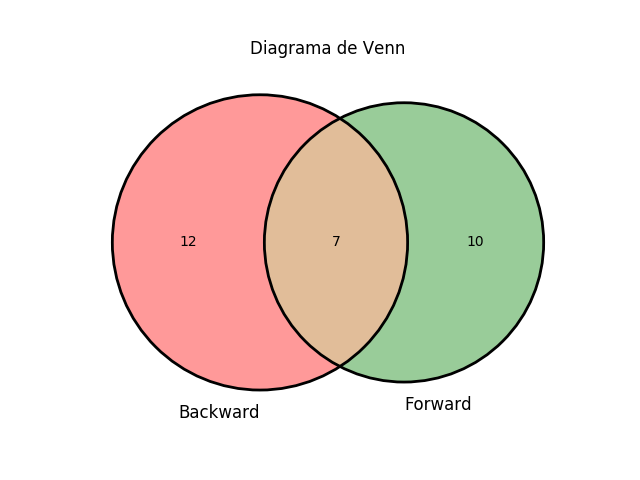

In [37]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [45]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['armbrust2010a', 'mandić2010d', 'mccoy1998a', 'basili2007c', 'lepmets2014a', 'hinley1995a', 'münch2013a', 'münch2013c', 'liu2005a', 'murugappan2003a', 'mcloughlin2010a', 'debou2000a', 'kowalczyk2010a', 'messnarz1999a', 'trendowicz2011a', 'martins2007b', 'liu2006a', 'basili2007b', 'basili2007a']
Forward ['cocozza2014a', 'mcloughlin2010b', 'trendowicz2014a', 'armbrust2010a', 'mandić2010d', 'münch2013a', 'münch2013c', 'karlström2002a', 'mcloughlin2010a', 'stallinger2013a', 'armbrust2010b', 'birkhölzer2011a', 'sun2010a', 'kowalczyk2010a', 'trendowicz2011a', 'trienekens2004a', 'unterkalmsteiner2014a']


In [46]:
state.find("s0").related @ metakey

['kautz2000a',
 'guzmán2010a',
 'wang2005a',
 'mandić2010b',
 'reiblein1997a',
 'barreto2010a',
 'oConnor2015a',
 'basili2010a',
 'plösch2011a',
 'wilkie2007a',
 'petersen2015a',
 'becker2008a',
 'becker2008b',
 'martins2008a',
 'sommerville1999a',
 'trienekens2009a',
 'mandić2010a',
 'waina2001a',
 'albuquerque2009a',
 'esfahani2011a',
 'trienekens2005a',
 'kaneko2011a']

In [47]:
#x = v.get_patch_by_id('100')

In [48]:
#x.set_linestyle = "black"

In [49]:
#[x.metakey for x in state.find("s0").related]

#### Execução de Backward (Aresta S0 -> S2) em cada artigo relacionado do S0

In [50]:
print("Descreve o S0 -> S2:\n Execução de Backward em cada artigo do related \n")
descreve_delta(strategy, state, "s2")

Descreve o S0 -> S2:
 Execução de Backward em cada artigo do related 

backward kautz2000a
- iversen1998a 
- hansen1998a 
- mcfeeley1996b 
- kautz1999a 
- brodman1994a 
- kautz2000b 
- kautz1999b 
- rogers1983a 
- hansen1998b 
- argyris1991a 
- borum1995a 
forward kautz2000a
- mishra2008a 
backward guzmán2010a
- ebert2007a 
- kamel2009a 
- harjumaa2008a 
- kaplan2005a 
- watson2007a 
- capell2004a 
- peng2007a 
- isoiec2008a 
- el2007a 
- kanji2007a 
- issac2006a 
- isoiec2007a 
- mcgarry2002a 
- isoiec2004a 
- tuan2006a 
- mehra2004a 
- chastek2009a 
- mcloone2007a 
- kaplan2008a 
- kaplan1997a 
- el2001a 
- oliveira2009a 
- kuppusamy2008a 
- long2008a 
- porter1979a 
- goethert2004a 
- basili2009b 
- card2003a 
- qi2007a 
- kaplan2006a 
- gopal2005a 
- lamb1984a 
- mishra2008a 
- shull2006a 
- sei2006b 
- dyba2005a 
- neergaard2007a 
- kahraman2007a 
- fahey2007a 
- asgarkhani2006a 
- goethert2003a 
backward wang2005a
- lawler2003a 
- kan2003a 
- sommerville2004a 
- paulk2000a 
- sti

#### Execução de Forward em cada artigo relacionado do S1

In [51]:
print("Descreve o S0 -> S1:\n Execução de Forward em cada artigo do related \n")
descreve_delta(strategy, state, "s1")

Descreve o S0 -> S1:
 Execução de Forward em cada artigo do related 

forward kautz2000a
- habib2008a 
- kautz2000c 
- hjalmarsson2004b 
- tjornehoj2008a 
- mas2005a 
- kasurinen2012a 
- farooq2007a 
- vähäniitty2003a 
- walker2007a 
- dagnino2014b 
- gon2012a 
- santos2011a 
- gruner2011a 
- sujaritha2007a 
- adamonis2005a 
- vähäniitty2003b 
- alagarsamy2007a 
- cater2004b 
- kasurinen2013a 
- wong2006a 
- kautz2001b 
- tjørnehøj2010a 
- casey2004a 
- preis2012a 
- gong2005a 
- pino2009a 
- leung2007a 
- sanders2008a 
- tjørnehøj2008a 
- leih2006a 
- svahnberg2013a 
- shen2008a 
- metodologia2009a 
- guerrero2004a 
- rasidi2008a 
- khdair2009a 
- balandis2005a 
- gorschek2012a 
- rodríguez2010a 
- kautz2004a 
- kauppinen2002a 
- kauppinen2004a 
- batista2009a 
- aysolmaz2011c 
- leite2010a 
- gorschek2004a 
- dagnino2014a 
- aysolmaz2011b 
- petersen2014a 
- kautz2001c 
- bertrand2008a 
- carter2001a 
- carter2001b 
- kauppinen2005a 
- bekkers2012a 
- hansen2004a 
- begum2010a 
- kau

#### Resumo do Precision e Recall

In [52]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)
print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))


Precision na Busca E2: 0.04%

Precision no Snowballing E2: 0.02%
Precision no Snowballing E2 - Forward - 1 iteração: 0.03%
Precision no Snowballing E2 - Backward - 1 iteração: 0.04%

Precision E2 (Busca + Snowballing): 0.03%
Precision E2
0.027229044313934865
Recall E2
1.0
F-measure E2
0.05301455301455302


In [53]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

20,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,ieee2015,0.139535,0.117647,0.12766,0,0,0,-,6,43,0,6,43,4,0.139535,0.117647,0.12766,0.0930233,0.133333,0.109589
1,sciencedirect2015,0.00512821,0.0196078,0.00813008,0,0,0,-,1,195,0,1,195,1,0.00512821,0.0196078,0.00813008,0.00512821,0.0333333,0.00888889
2,webofscience2015,0.5,0.0980392,0.163934,0,0,0,-,5,10,0,5,10,4,0.5,0.0980392,0.163934,0.4,0.133333,0.2
3,elcompendex2015,0.384615,0.0980392,0.15625,0,0,0,-,5,13,0,5,13,5,0.384615,0.0980392,0.15625,0.384615,0.166667,0.232558
4,springer2015,0.0141844,0.0392157,0.0208333,0,0,0,-,2,141,0,2,141,1,0.0141844,0.0392157,0.0208333,0.0070922,0.0333333,0.0116959
5,scopus2015,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
6,acm2015,0.05,0.0980392,0.0662252,0,0,0,-,5,100,0,5,100,3,0.05,0.0980392,0.0662252,0.03,0.1,0.0461538
7,s0,NaN,0,0,NaN,0,0,union,0,0,0,22,497,15,0.0442656,0.431373,0.080292,0.0301811,0.5,0.056926
8,s2,0.0410256,0.313725,0.0725624,0.0205128,0.266667,0.0380952,backward,16,390,8,38,887,23,0.042841,0.745098,0.0810235,0.0259301,0.766667,0.0501636
9,s1,0.0334262,0.235294,0.0585366,0.0139276,0.166667,0.0257069,forward,12,359,5,34,856,20,0.0397196,0.666667,0.0749724,0.0233645,0.666667,0.0451467


In [54]:
df["state"]  + "\n" + df["operation"]

0              ieee2015\n-
1     sciencedirect2015\n-
2      webofscience2015\n-
3       elcompendex2015\n-
4          springer2015\n-
5            scopus2015\n-
6               acm2015\n-
7                s0\nunion
8             s2\nbackward
9              s1\nforward
10               s3\nunion
11            s5\nbackward
12             s4\nforward
13               s6\nunion
14            s8\nbackward
15             s7\nforward
16               s9\nunion
17           s11\nbackward
18            s10\nforward
19              s12\nunion
dtype: object

<IPython.core.display.Javascript object>


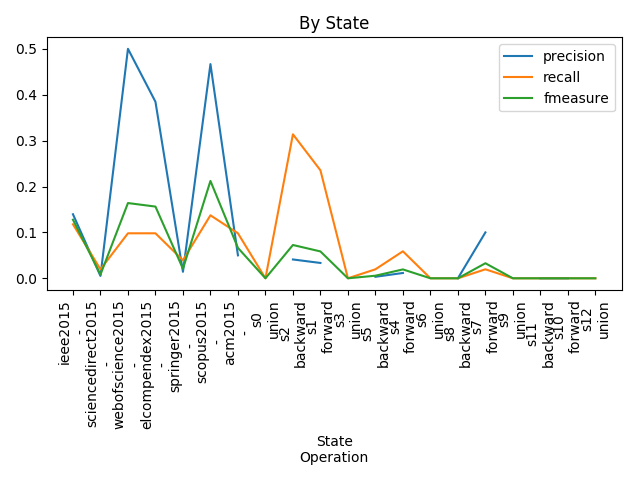

In [55]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

<IPython.core.display.Javascript object>


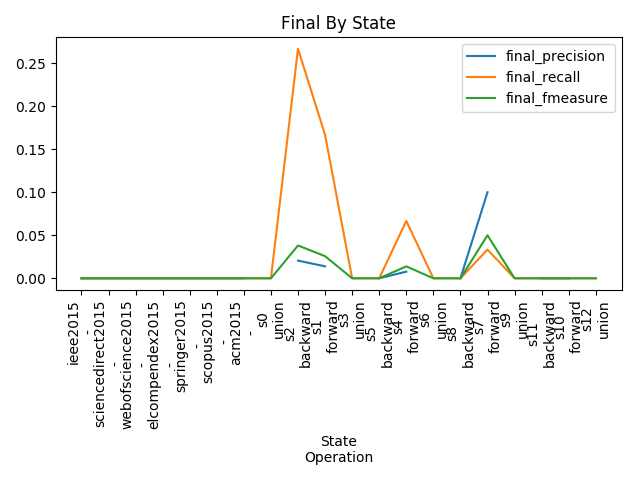

In [58]:
fig = plt.figure()
df['final_precision'].plot(legend=True)
df['final_recall'].plot(legend=True)
df['final_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Final By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

<IPython.core.display.Javascript object>


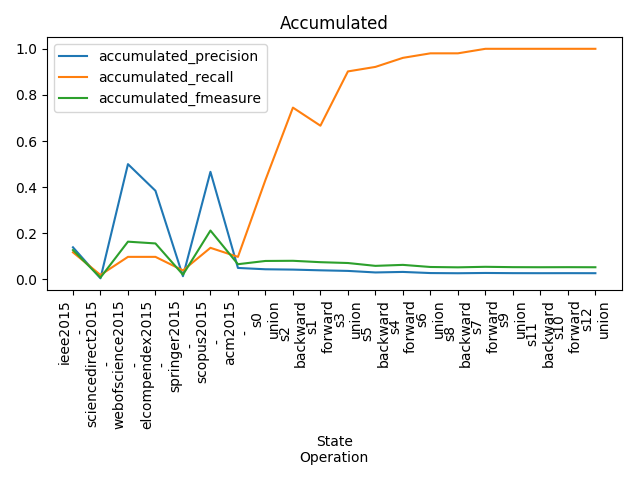

In [62]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()

<IPython.core.display.Javascript object>


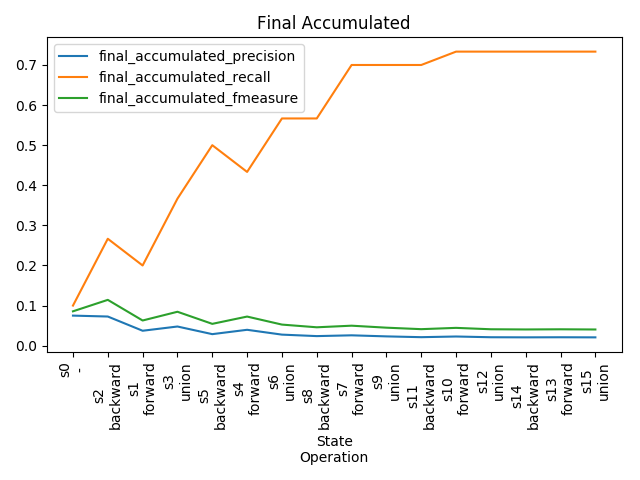

In [71]:
fig = plt.figure()
df['final_accumulated_precision'].plot(legend=True)
df['final_accumulated_recall'].plot(legend=True)
df['final_accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Final Accumulated");
plt.tight_layout()

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

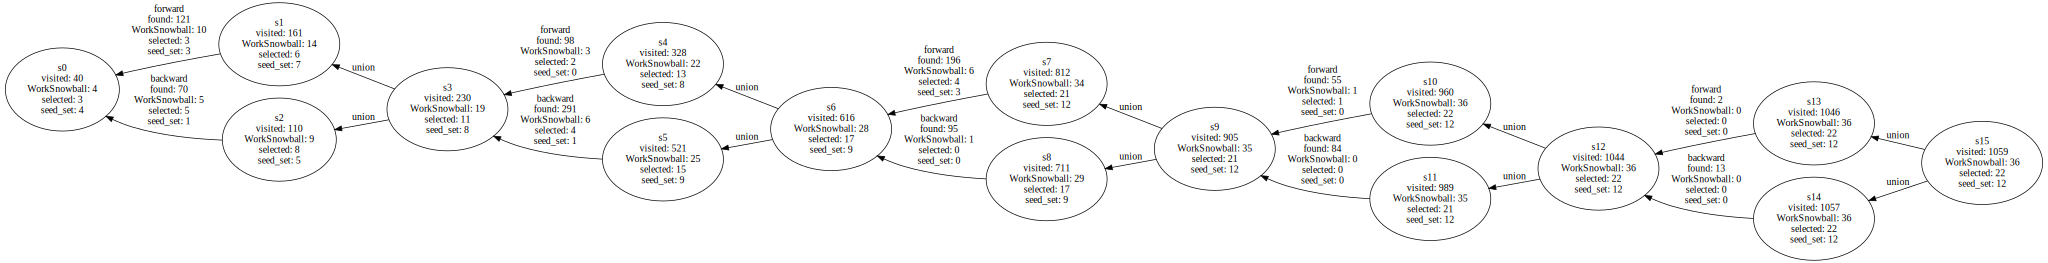

In [85]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
FinalSelection(state)

In [86]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))

Precision E3
0.0339943342776204
Recall E3
0.7058823529411765
F-measure E3
0.06486486486486487


In [87]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

16,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.1,0.0784314,0.0879121,0,0,0,-,4,40,0,4,40,3,0.1,0.0784314,0.0879121,0.075,0.1,0.0857143
1,s2,0.0714286,0.0980392,0.0826446,0.0714286,0.166667,0.1,backward,5,70,5,9,110,8,0.0818182,0.176471,0.111801,0.0727273,0.266667,0.114286
2,s1,0.0826446,0.196078,0.116279,0.0247934,0.1,0.0397351,forward,10,121,3,14,161,6,0.0869565,0.27451,0.132075,0.0372671,0.2,0.0628272
3,s3,NaN,0,0,NaN,0,0,union,0,0,0,19,230,11,0.0826087,0.372549,0.135231,0.0478261,0.366667,0.0846154
4,s5,0.0206186,0.117647,0.0350877,0.0137457,0.133333,0.0249221,backward,6,291,4,25,521,15,0.0479846,0.490196,0.0874126,0.0287908,0.5,0.0544465
5,s4,0.0306122,0.0588235,0.0402685,0.0204082,0.0666667,0.03125,forward,3,98,2,22,328,13,0.0670732,0.431373,0.116095,0.0396341,0.433333,0.0726257
6,s6,NaN,0,0,NaN,0,0,union,0,0,0,28,616,17,0.0454545,0.54902,0.083958,0.0275974,0.566667,0.0526316
7,s8,0.0105263,0.0196078,0.0136986,0,0,0,backward,1,95,0,29,711,17,0.0407876,0.568627,0.0761155,0.02391,0.566667,0.0458839
8,s7,0.0306122,0.117647,0.048583,0.0204082,0.133333,0.0353982,forward,6,196,4,34,812,21,0.0418719,0.666667,0.0787949,0.0258621,0.7,0.0498812
9,s9,NaN,0,0,NaN,0,0,union,0,0,0,35,905,21,0.038674,0.686275,0.0732218,0.0232044,0.7,0.0449198



## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

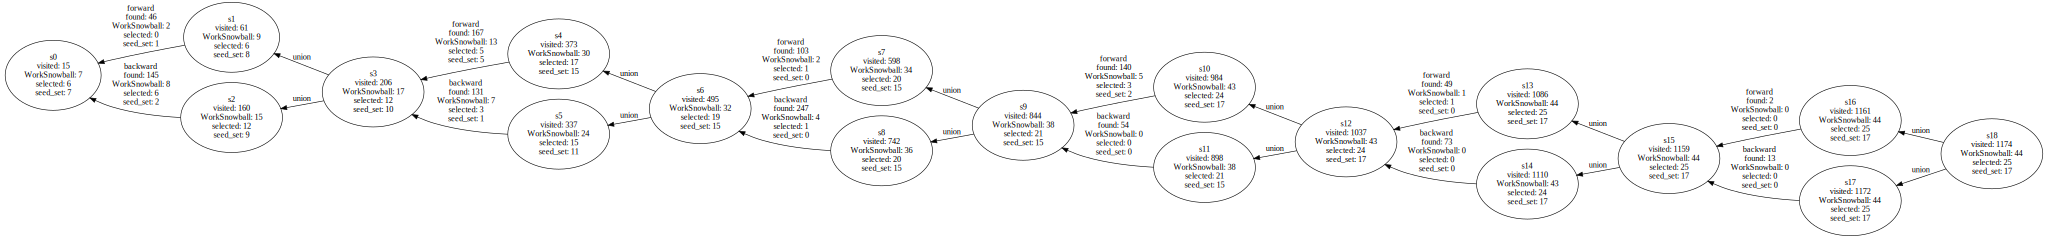

In [88]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
FinalSelection(state)

In [89]:
descreve_delta(strategy, state, "s2")


backward albuquerque2009a
- komi2004a 
- isoiec2004b 
- cater2004a 
- reed2000a 
- salo2005b 
- hefner2001a 
- softex2009a 
- nollen2008a 
- birk2002a 
- alloui2000a 
- adams1993a 
- isoiec2004a 
- thompson2000a 
- kaplan2000a 
- boehm2000b 
- kim1995a 
- birk1998a 
- prahalad1999a 
- caivano2005a 
- wright2000a 
- mcnair1990a 
- stalhane2004a 
- cmusei2006a 
- lawrence2001a 
- bardin1977a 
- dybå2003b 
- martins2007b related
backward becker2008a
- chrissis2003a 
- cox1992a 
- isoiec2003a 
- brodman1995a 
- yin2003a 
- pulford1996a 
- mccoy1998a related
- montoni2007a 
- pitterman2000a 
- grady1997a 
- zaijun2005a 
- peterson1995a 
- paulk1993a 
- yamamura1999a 
- debou1999a 
- liu2005a related
- akao1990a 
- zahran1998a 
- dyba2005a 
- hierholzer1998a 
- biró1999a 
- niazi2003a 
- weber2005a 
- humphrey1989b 
backward plösch2011a
- venzin2003a 
- isoiec2003b 
- simon2002a 
- dion1993a 
- shewhart1931a 
- isoiec1998d 
- mcfeeley1996a 
- cmmi2006a 
backward guzmán2010a
- ebert2007a 
- k

In [90]:
texto = """backward becker2008a
- weber2005a 
- hierholzer1998a 
- debou1999a 
- liu2005a 
- yamamura1999a 
- cox1992a 
- grady1997a 
- biró1999a 
- mccoy1998a 
- dyba2005a 
- humphrey1989b 
- paulk1993a 
- chrissis2003a 
- zaijun2005a 
- peterson1995a 
- brodman1995a 
- akao1990a 
- pitterman2000a 
- pulford1996a 
- montoni2007a 
- yin2003a 
- isoiec2003a 
- zahran1998a 
- niazi2003a 
backward martins2008a
- arthur1993a 
- isoiec1998a 
- salo2005a 
- krasner1997a 
- kuvaja1994a 
- cmm2002a 
- isoiec1998c 
- isoiec1998b 
- emam1999a 
- pfleeger1994a 
- solingen1999a 
- paulk1993a 
- vertage1994a 
- martins2007b 
backward reiblein1997a
- kaplan1993a 
- miller1995a 
- trade1992a 
- hinley1997a 
- vlasveld1995a 
- deming1986a 
- group1997a 
- iso1994b 
- itil1989a 
- iso1994a 
- cmm1993a 
- humphrey1989a 
- isoies1997a 
- kaplan1996b 
backward albuquerque2009a
- birk2002a 
- stalhane2004a 
- prahalad1999a 
- softex2009a 
- boehm2000b 
- cmusei2006a 
- nollen2008a 
- salo2005b 
- wright2000a 
- isoiec2004a 
- lawrence2001a 
- reed2000a 
- cater2004a 
- dybå2003b 
- birk1998a 
- bardin1977a 
- hefner2001a 
- thompson2000a 
- kim1995a 
- isoiec2004b 
- alloui2000a 
- caivano2005a 
- mcnair1990a 
- kaplan2000a 
- adams1993a 
- komi2004a 
- martins2007b 
backward kaneko2011a
- kathuria2007a 
- isaca2005a 
- kaplan1992a 
- basili2009a 
- basili2007b 
- becker1999a 
- isaca2008a 
- ogc2002a 
- basili1992a 
- jaxa2012a 
- kowalczyk2010a 
backward guzmán2010a
- ebert2007a 
- mcgarry2002a 
- goethert2004a 
- kaplan2008a 
- chastek2009a 
- tuan2006a 
- basili2009b 
- el2007a 
- sei2006b 
- kojima2008a 
- mishra2008a 
- long2008a 
- watson2007a 
- kanji2007a 
- oliveira2009a 
- porter1979a 
- lamb1984a 
- isoiec2007a 
- asgarkhani2006a 
- harjumaa2008a 
- mcloone2007a 
- mehra2004a 
- kamel2009a 
- card2003a 
- neergaard2007a 
- basili2010a related
- kaplan2005a 
- gopal2005a 
- peng2007a 
- kahraman2007a 
- isoiec2004a 
- fahey2007a 
- kaplan2006a 
- trienekens2009a related
- dyba2005a 
- shull2006a 
- el2001a 
- qi2007a 
- issac2006a 
- isoiec2008a 
- kaplan1997a 
- kuppusamy2008a 
- capell2004a 
- goethert2003a 
backward wilkie2007a
- iso2006a 
- anacleto2004b 
- wilkie2005a 
- mcfeeley1996a 
- anacleto2004a 
- makinen2000a 
- caffery2004a 
- sei2004a 
- wilkie2004a 
- cspt2003a 
- institute2005a 
- chrissis2003a 
- ISOIEC2006a 
- caffery2005a 
- mcfall2003a 
- sei2005a 
- paulk1995a 
- cignoni1999a 
- team2007a 
- rout2001a 
backward plösch2011a
- shewhart1931a 
- isoiec2003b 
- simon2002a 
- venzin2003a 
- cmmi2006a 
- mcfeeley1996a 
- isoiec1998d 
- dion1993a"""

In [91]:
conjuntos = [set(x.split("-")[1:]) for x in texto.split("backward")[1:]]

In [92]:
conjuntos[0] & conjuntos[1]

{' paulk1993a \n'}

In [93]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))

Precision E4
0.03747870528109029
Recall E4
0.8627450980392157
F-measure E4
0.07183673469387755


In [94]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

19,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
1,s2,0.0551724,0.156863,0.0816327,0.0413793,0.2,0.0685714,backward,8,145,6,15,160,12,0.09375,0.294118,0.14218,0.075,0.4,0.126316
2,s1,0.0434783,0.0392157,0.0412371,0,0,0,forward,2,46,0,9,61,6,0.147541,0.176471,0.160714,0.0983607,0.2,0.131868
3,s3,NaN,0,0,NaN,0,0,union,0,0,0,17,206,12,0.0825243,0.333333,0.132296,0.0582524,0.4,0.101695
4,s5,0.0534351,0.137255,0.0769231,0.0229008,0.1,0.0372671,backward,7,131,3,24,337,15,0.0712166,0.470588,0.123711,0.0445104,0.5,0.0817439
5,s4,0.0778443,0.254902,0.119266,0.0299401,0.166667,0.0507614,forward,13,167,5,30,373,17,0.080429,0.588235,0.141509,0.0455764,0.566667,0.0843672
6,s6,NaN,0,0,NaN,0,0,union,0,0,0,32,495,19,0.0646465,0.627451,0.117216,0.0383838,0.633333,0.072381
7,s8,0.0161943,0.0784314,0.0268456,0.00404858,0.0333333,0.00722022,backward,4,247,1,36,742,20,0.0485175,0.705882,0.0907945,0.0269542,0.666667,0.0518135
8,s7,0.0194175,0.0392157,0.025974,0.00970874,0.0333333,0.0150376,forward,2,103,1,34,598,20,0.0568562,0.666667,0.104777,0.0334448,0.666667,0.0636943
9,s9,NaN,0,0,NaN,0,0,union,0,0,0,38,844,21,0.0450237,0.745098,0.0849162,0.0248815,0.7,0.0480549


In [95]:
state.find("s0").related

{Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [96]:
state.find("s2").related

{Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 A goal-oriented approach for managing software process change,
 Linking software development and business strategy through measurement,
 GQM+Strategies - Aligning business strategies with software measurement,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Aligning software-related strategies in multi-organizational settings,
 Entropy based software processes improvement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 ProPAM: SPI based on Process and Project Alignment,
 Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics,
 QFD application in software process management and improvement based

In [97]:
state.find("s0").visited

{Using strategic planning for selection of SPI processes: An experience report,
 An approach to support the strategic alignment of software process improvement programs,
 Linking software life cycle activities with product strategy and economics: Extending ISO/IEC 12207 with product management best practices,
 Empirical evaluation of selected best practices in implementation of software process improvement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 Software process improvement for the airline industry,
 Demanding change: How to remain in business despite IT,
 Alignment between the business strategy and the software processes improvement: A roadmap for the implementation [Alinhamento entre estrategia de negocios e melhoria de processos de software: Um roteiro de implementacao],
 Critical success factors in software process improvement: A systematic review,
 SPI:I can't 

In [98]:
strategy

In [99]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [100]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

In [101]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

set()

In [102]:
len(state.find("s1").delta_visited)

46

In [103]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

0

In [104]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

0

In [105]:
search_state = strategy.initial
search_state.related

{Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

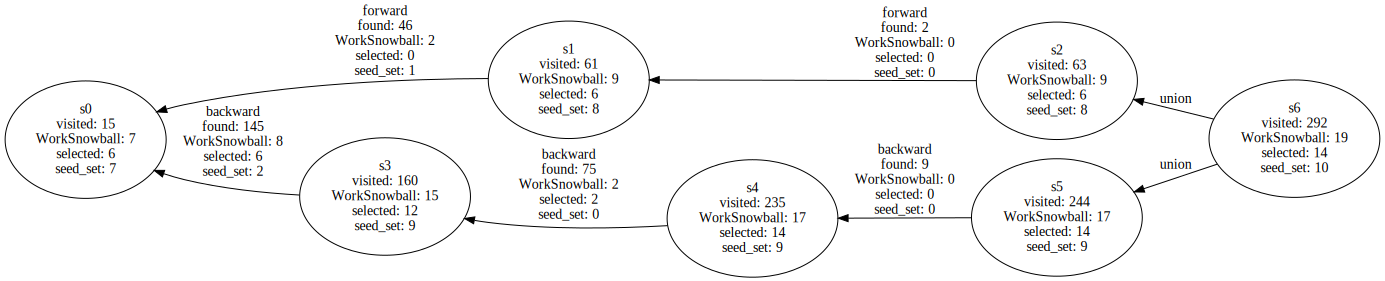

In [106]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.s2bbff2u()
FinalSelection(state)

In [107]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))

Precision E5
0.06506849315068493
Recall E5
0.37254901960784315
F-measure E5
0.11078717201166181


In [108]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

7,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s3,0.0551724,0.156863,0.0816327,0.0413793,0.2,0.0685714,backward,8,145,6,15,160,12,0.09375,0.294118,0.14218,0.075,0.4,0.126316
1,s0,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
2,s4,0.0266667,0.0392157,0.031746,0.0266667,0.0666667,0.0380952,backward,2,75,2,17,235,14,0.0723404,0.333333,0.118881,0.0595745,0.466667,0.10566
3,s1,0.0434783,0.0392157,0.0412371,0,0,0,forward,2,46,0,9,61,6,0.147541,0.176471,0.160714,0.0983607,0.2,0.131868
4,s5,0,0,0,0,0,0,backward,0,9,0,17,244,14,0.0696721,0.333333,0.115254,0.057377,0.466667,0.10219
5,s2,0,0,0,0,0,0,forward,0,2,0,9,63,6,0.142857,0.176471,0.157895,0.0952381,0.2,0.129032
6,s6,NaN,0,0,NaN,0,0,union,0,0,0,19,292,14,0.0650685,0.372549,0.110787,0.0479452,0.466667,0.0869565


In [109]:
state.find("s0").related 

{Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [110]:
state.find("s1").related 

{Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach,
 Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI),
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [111]:
state.find("s3").related 

{Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 A goal-oriented approach for managing software process change,
 Linking software development and business strategy through measurement,
 GQM+Strategies - Aligning business strategies with software measurement,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Aligning software-related strategies in multi-organizational settings,
 Entropy based software processes improvement,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 ProPAM: SPI based on Process and Project Alignment,
 Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics,
 QFD application in software process management and improvement based

In [112]:
sx, sy = state.previous[0]

sx.related & sy.related


{Software process improvement: Supporting the linking of the software and the business strategies,
 An approach to support the strategic alignment of software process improvement programs,
 Software engineering strategies: aligning software process improvement with strategic goals,
 Integration of strategic management, process improvement and quantitative measurement for managing the competitiveness of software engineering organizations,
 A Low-overhead method for software process appraisal,
 Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 SPI:I can't get no satisfaction-directing process improvement to meet business needs}

In [113]:
sx.name

's2'

In [114]:
sy.name

's5'

In [115]:
# Artigos encontrados via Backward e Forward - Foi incluído kitchenham 2007a como Snowball para o teste.
print ("Encontrados via Backward e Forward:")
separa_backward_forward(state) @ metakey_title

Encontrados via Backward e Forward:


[['hinley1995a - A goal-oriented approach for managing software process change',
  'trienekens2009a - Entropy based software processes improvement',
  'mccoy1998a - Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics',
  'liu2005a - QFD application in software process management and improvement based on CMM',
  'basili2007c - GQM+ Strategies: A comprehensive methodology for aligning business strategies with software measurement',
  'basili2010a - Linking software development and business strategy through measurement',
  'kowalczyk2010a - Aligning software-related strategies in multi-organizational settings',
  'martins2007b - ProPAM: SPI based on Process and Project Alignment',
  'basili2007b - GQM+Strategies - Aligning business strategies with software measurement',
  'basili2007a - Bridging the gap between business strategy and software development'],
 ['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies 

In [116]:
# S1 - Forward (Related) - Encontrados na iteração 1
print("Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:")
state.find("s1").delta_related @ metakey_title

Relacionados encontrados via Forward, para chegar ao Estado 1, a partir do Estado 0:


['petersen2015a - An elicitation instrument for operationalising GQM+ Strategies (GQM+ S-EI)',
 'stallinger2013a - Development and Evaluation of Systems Engineering Strategies: An Assessment-Based Approach']

## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

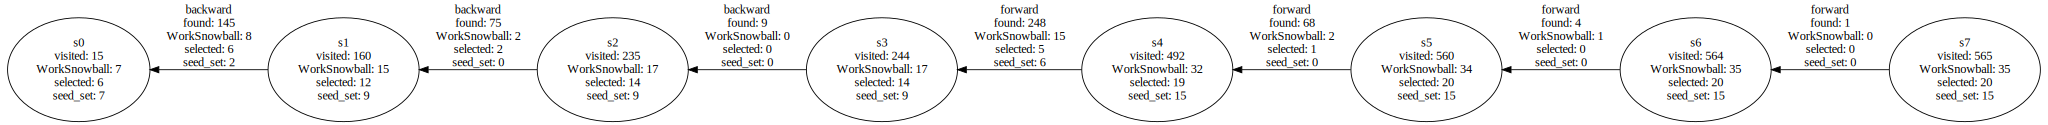

In [117]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.bbff()
FinalSelection(state)

In [118]:
strategy._repeat??

In [119]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

#array.append((name, EP, ER, FS))

Precision E6
0.061946902654867256
Recall E6
0.6862745098039216
F-measure E6
0.11363636363636363


In [120]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

8,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
1,s1,0.0551724,0.156863,0.0816327,0.0413793,0.2,0.0685714,backward,8,145,6,15,160,12,0.09375,0.294118,0.14218,0.075,0.4,0.126316
2,s2,0.0266667,0.0392157,0.031746,0.0266667,0.0666667,0.0380952,backward,2,75,2,17,235,14,0.0723404,0.333333,0.118881,0.0595745,0.466667,0.10566
3,s3,0,0,0,0,0,0,backward,0,9,0,17,244,14,0.0696721,0.333333,0.115254,0.057377,0.466667,0.10219
4,s4,0.0604839,0.294118,0.100334,0.0201613,0.166667,0.0359712,forward,15,248,5,32,492,19,0.0650407,0.627451,0.117864,0.0386179,0.633333,0.0727969
5,s5,0.0294118,0.0392157,0.0336134,0.0147059,0.0333333,0.0204082,forward,2,68,1,34,560,20,0.0607143,0.666667,0.111293,0.0357143,0.666667,0.0677966
6,s6,0.25,0.0196078,0.0363636,0,0,0,forward,1,4,0,35,564,20,0.0620567,0.686275,0.113821,0.035461,0.666667,0.0673401
7,s7,0,0,0,0,0,0,forward,0,1,0,35,565,20,0.0619469,0.686275,0.113636,0.0353982,0.666667,0.0672269


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

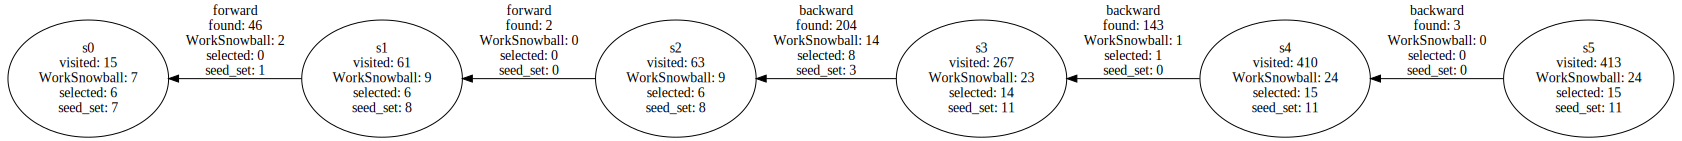

In [121]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.ffbb()
FinalSelection(state)

In [122]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

print ("F-measure " + name)
FS = 2*((EP*ER)/(EP+ER))
print (FS)

print ("Final Precision " + name)
FEP = len (state.final_selected) / len (state.visited)
print (FEP)
print ("Final Recall " + name)
FER = len (state.final_selected) / len (TOTAL)
print (FER)

print ("Final F-measure " + name)
FFS = 2*((FEP*FER)/(FEP+FER))
print (FFS)

#array.append((name, EP, ER, FS, FEP, FER, FFS))

Precision E7
0.05811138014527845
Recall E7
0.47058823529411764
F-measure E7
0.10344827586206896
Final Precision E7
0.03631961259079903
Final Recall E7
0.29411764705882354
Final F-measure E7
0.06465517241379311


In [123]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

6,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
1,s1,0.0434783,0.0392157,0.0412371,0,0,0,forward,2,46,0,9,61,6,0.147541,0.176471,0.160714,0.0983607,0.2,0.131868
2,s2,0,0,0,0,0,0,forward,0,2,0,9,63,6,0.142857,0.176471,0.157895,0.0952381,0.2,0.129032
3,s3,0.0686275,0.27451,0.109804,0.0392157,0.266667,0.0683761,backward,14,204,8,23,267,14,0.0861423,0.45098,0.144654,0.0524345,0.466667,0.0942761
4,s4,0.00699301,0.0196078,0.0103093,0.00699301,0.0333333,0.0115607,backward,1,143,1,24,410,15,0.0585366,0.470588,0.104121,0.0365854,0.5,0.0681818
5,s5,0,0,0,0,0,0,backward,0,3,0,24,413,15,0.0581114,0.470588,0.103448,0.0363196,0.5,0.0677201


# Análise das Estratégias

In [124]:
%matplotlib notebook
import pandas as pd

In [125]:
df = pd.DataFrame (array,columns = [
    'Estratégia', 'Related', 'Visited', 'Final Selected', 
    'Precision', 'Recall', 'F-Measure',
    'Final Precision', 'Final Recall', 'Final F-Measure'])
df.index = df['Estratégia']
df

,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,6,43,4,0.139535,0.117647,0.127660,0.093023,0.133333,0.109589
E2,E2,51,1873,30,0.027229,1.000000,0.053015,0.016017,1.000000,0.031529
E3,E3,36,1059,22,0.033994,0.705882,0.064865,0.020774,0.733333,0.040404
E3,E3,36,1059,22,0.033994,0.705882,0.064865,0.020774,0.733333,0.040404
E4,E4,44,1174,25,0.037479,0.862745,0.071837,0.021295,0.833333,0.041528
E3,E3,36,1059,22,0.033994,0.705882,0.064865,0.020774,0.733333,0.040404
E4,E4,44,1174,25,0.037479,0.862745,0.071837,0.021295,0.833333,0.041528
E5,E5,19,292,14,0.065068,0.372549,0.110787,0.047945,0.466667,0.086957
E6,E6,35,565,20,0.061947,0.686275,0.113636,0.035398,0.666667,0.067227


<IPython.core.display.Javascript object>


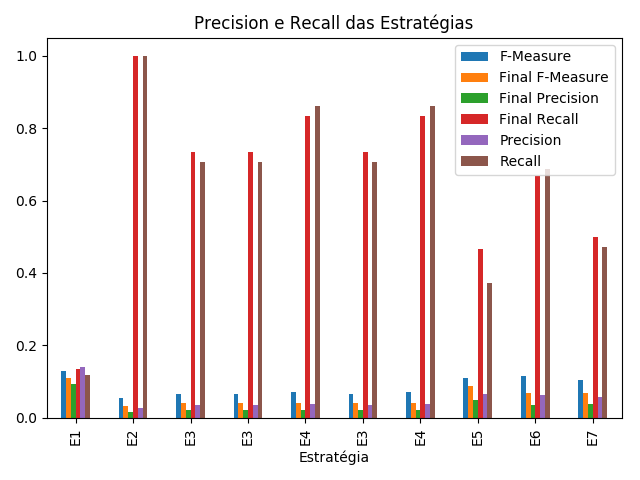

In [126]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df.loc[:, df.columns.difference(exclude)].plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [131]:
df

,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,6,43,4,0.139535,0.117647,0.127660,0.093023,0.133333,0.109589
E2,E2,51,1873,30,0.027229,1.000000,0.053015,0.016017,1.000000,0.031529
E3,E3,36,1059,22,0.033994,0.705882,0.064865,0.020774,0.733333,0.040404
E3,E3,36,1059,22,0.033994,0.705882,0.064865,0.020774,0.733333,0.040404
E4,E4,44,1174,25,0.037479,0.862745,0.071837,0.021295,0.833333,0.041528
E3,E3,36,1059,22,0.033994,0.705882,0.064865,0.020774,0.733333,0.040404
E4,E4,44,1174,25,0.037479,0.862745,0.071837,0.021295,0.833333,0.041528
E5,E5,19,292,14,0.065068,0.372549,0.110787,0.047945,0.466667,0.086957
E6,E6,35,565,20,0.061947,0.686275,0.113636,0.035398,0.666667,0.067227


In [132]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

# Individual

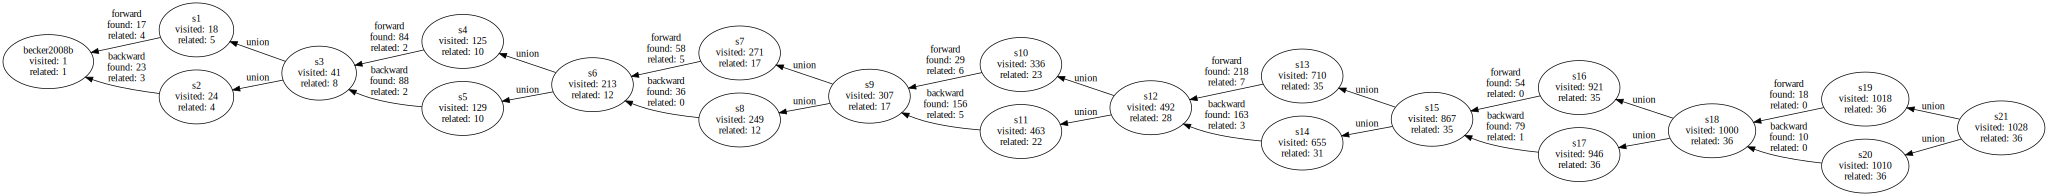

In [133]:
reload()
#NAME = "guzmán2010a"
NAME = "becker2008b"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

In [136]:
state.find("s1").delta_visited @ metakey_title

['armbrust2010a - Determining organization-specific process suitability',
 'chebrolu2013a - How does alignment of business and IT strategies impact aspects of IT effectiveness?',
 'aversano2013a - Goal-driven Approach for Business/IT Alignment Evaluation',
 'lópez2012a - Software process improvement as an organizational self-production process',
 'barreto2010a - Defining and monitoring strategically aligned software improvement goals',
 'escofet2009a - Strategic alignment as a way of addressing the barriers to e-business adoption',
 'armbrust2010b - Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA)',
 'escofet2010a - Strategic E-Business/IT Alignment for SME Competitiveness',
 'barreto2011a - Defini{ç}ão e Gerência de Objetivos de Software Alinhados ao Planejamento Estratégico',
 'lang2013b - 소프트웨어 개선을 위한 사용자 그룹 기반의 Kano 모델 적용 방안',
 'lang2013a - 소프트웨어 개선을 위한 사용자 경험 수준 기반의 Kano 모델 적용',
 'sun2010a - Business-

In [137]:
state.find("s1").delta_related @ metakey_title

['barreto2010a - Defining and monitoring strategically aligned software improvement goals',
 'armbrust2010a - Determining organization-specific process suitability',
 'sun2010a - Business-oriented software process improvement based on CMMI using QFD',
 'armbrust2010b - Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA)']

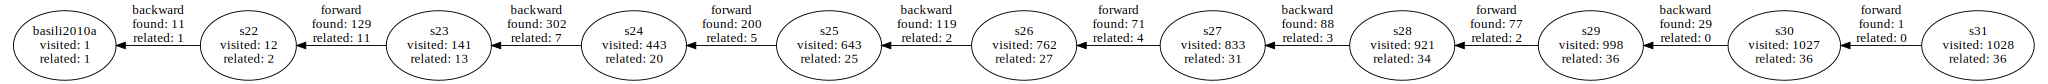

In [98]:
strategy.bfbf()